<a href="https://colab.research.google.com/github/thanhquye/Traffic-sign-classification/blob/huuquy/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Machine_Learning/Project'

/content/drive/MyDrive/Machine_Learning/Project


In [ ]:
train_path = './Train'
test_path = './Test'

In [ ]:
test_df = pd.read_csv('Test.csv')

In [ ]:
test_df

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


In [ ]:
height = 50
width = 50
batch_size = 64
seed = 42

In [ ]:
%ls

CNN.h5     data.zip    meta/  Meta.csv  Test/     train/  Train.csv        unzip.ipynb
cnn.ipynb  load.ipynb  Meta/  test/     Test.csv  Train/  Untitled1.ipynb


In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left', 20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',  37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

Found 31368 images belonging to 43 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 7841 images belonging to 43 classes.


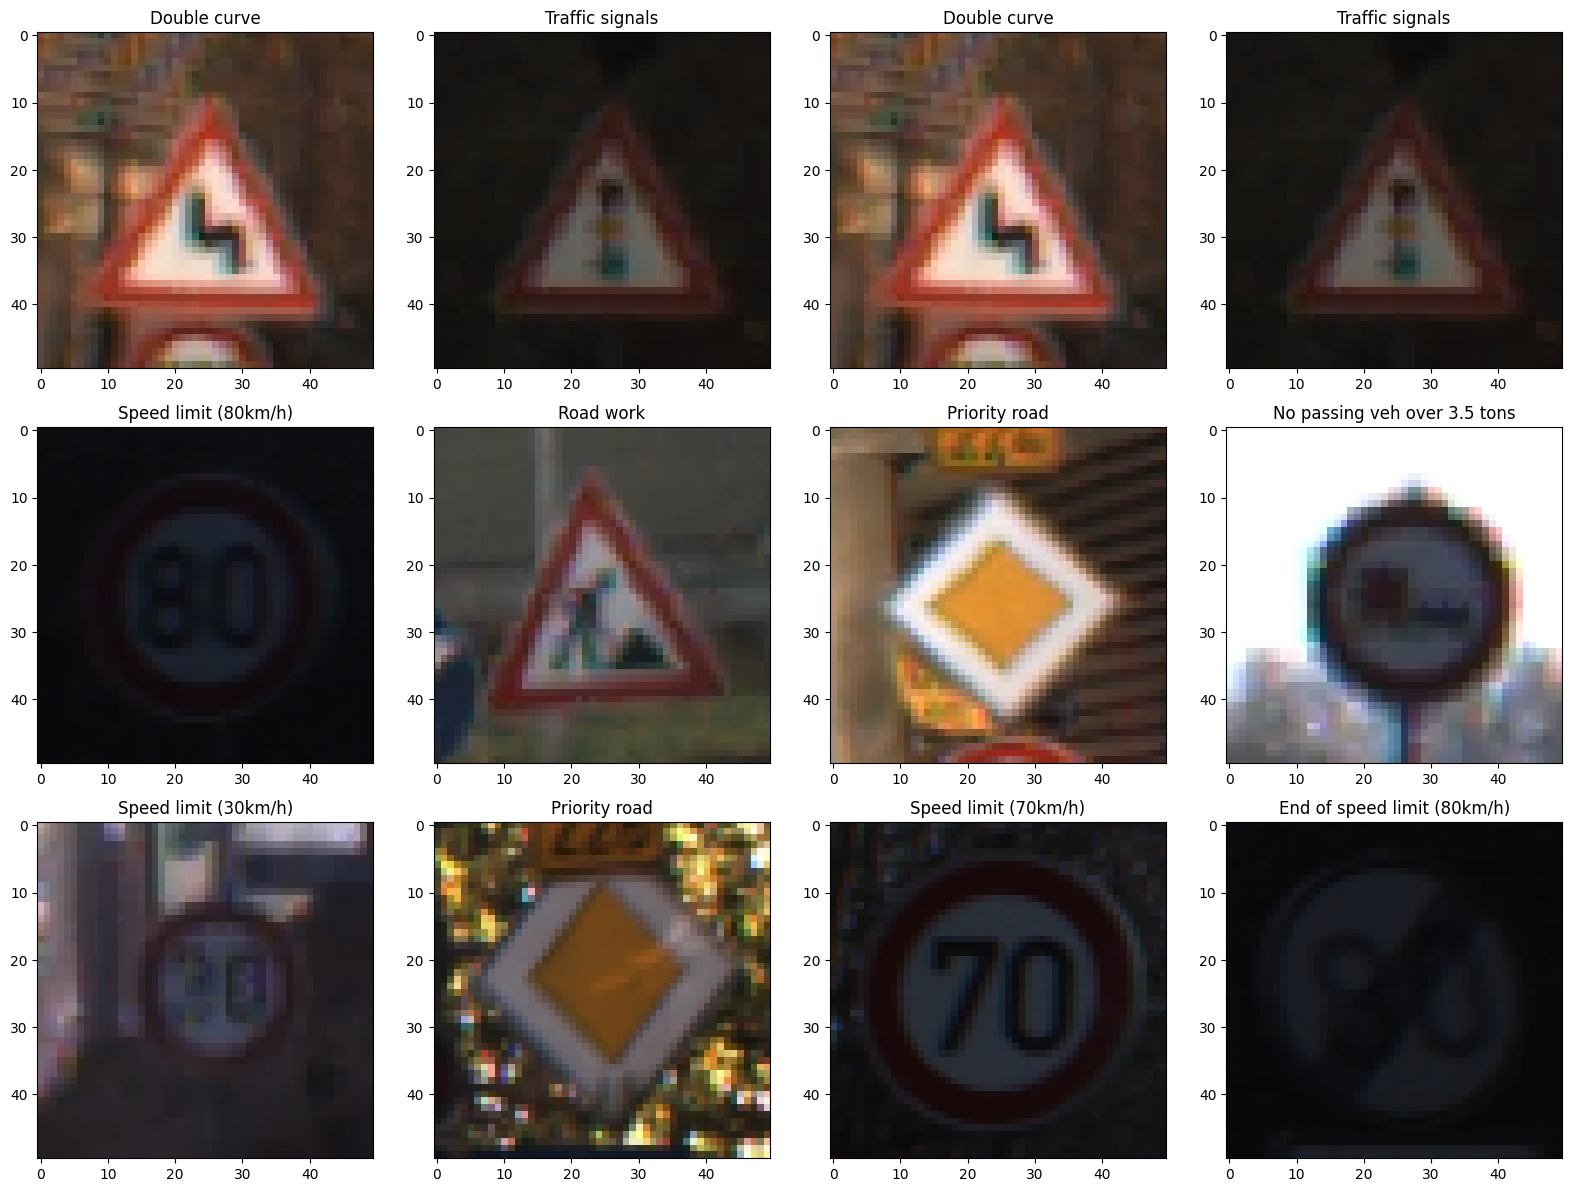

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

In [ ]:
classes = sorted(os.listdir(train_path), key=int)

In [ ]:
classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42']

In [ ]:
# Get the number of images for each class
class_counts = {}
for class_num in classes:
    class_path = os.path.join(train_path, class_num)
    class_count = len(os.listdir(class_path))
    class_counts[class_num] = class_count

In [ ]:
# Get the total number of images in the dataset
total_count = sum(class_counts.values())

In [ ]:
# Get the number of images for train, test, and validation sets
train_count = int(total_count * 0.8)  # 80% for training
test_count = int(total_count * 0.1)  # 10% for testing
val_count = total_count - train_count - test_count  # Remaining for validation

In [ ]:
# Calculate the percentages
train_percent = (train_count / total_count) * 100
test_percent = (test_count / total_count) * 100
val_percent = (val_count / total_count) * 100


In [ ]:
# Print the information
print("Total Images:", total_count)
print("Images per Class:")
for class_num in classes:
    count = class_counts[class_num]
    print(f"Class {class_num}: {count}")
print("Train Images:", train_count, f"({train_percent:.2f}%)")
print("Test Images:", test_count, f"({test_percent:.2f}%)")
print("Validation Images:", val_count, f"({val_percent:.2f}%)")

Total Images: 39209
Images per Class:
Class 0: 210
Class 1: 2220
Class 2: 2250
Class 3: 1410
Class 4: 1980
Class 5: 1860
Class 6: 420
Class 7: 1440
Class 8: 1410
Class 9: 1470
Class 10: 2010
Class 11: 1320
Class 12: 2100
Class 13: 2160
Class 14: 780
Class 15: 630
Class 16: 420
Class 17: 1110
Class 18: 1200
Class 19: 210
Class 20: 360
Class 21: 330
Class 22: 390
Class 23: 510
Class 24: 270
Class 25: 1500
Class 26: 600
Class 27: 240
Class 28: 540
Class 29: 270
Class 30: 450
Class 31: 780
Class 32: 240
Class 33: 689
Class 34: 420
Class 35: 1200
Class 36: 390
Class 37: 210
Class 38: 2070
Class 39: 300
Class 40: 360
Class 41: 240
Class 42: 240
Train Images: 31367 (80.00%)
Test Images: 3920 (10.00%)
Validation Images: 3922 (10.00%)


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(height,width,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.25),

    keras.layers.Dense(43, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 32)        12832     
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 21, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 21, 21, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 64)        3

In [ ]:
alpha=0.0001
epochs=10
optim = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset))

Epoch 1/10
491/491 [==============================] - 13948s 28s/step - loss: 0.9069 - accuracy: 0.7704 - val_loss: 0.9161 - val_accuracy: 0.7657
Epoch 2/10
491/491 [==============================] - 452s 919ms/step - loss: 0.1292 - accuracy: 0.9717 - val_loss: 0.3265 - val_accuracy: 0.9036
Epoch 3/10
491/491 [==============================] - 448s 912ms/step - loss: 0.0568 - accuracy: 0.9889 - val_loss: 0.2839 - val_accuracy: 0.9203
Epoch 4/10
491/491 [==============================] - 448s 912ms/step - loss: 0.0308 - accuracy: 0.9946 - val_loss: 0.2563 - val_accuracy: 0.9260
Epoch 5/10
491/491 [==============================] - 450s 915ms/step - loss: 0.0178 - accuracy: 0.9978 - val_loss: 0.2152 - val_accuracy: 0.9408
Epoch 6/10
491/491 [==============================] - 452s 918ms/step - loss: 0.0124 - accuracy: 0.9983 - val_loss: 0.2264 - val_accuracy: 0.9341
Epoch 7/10
491/491 [==============================] - 452s 920ms/step - loss: 0.0083 - accuracy: 0.9992 - val_loss: 0.2099 -

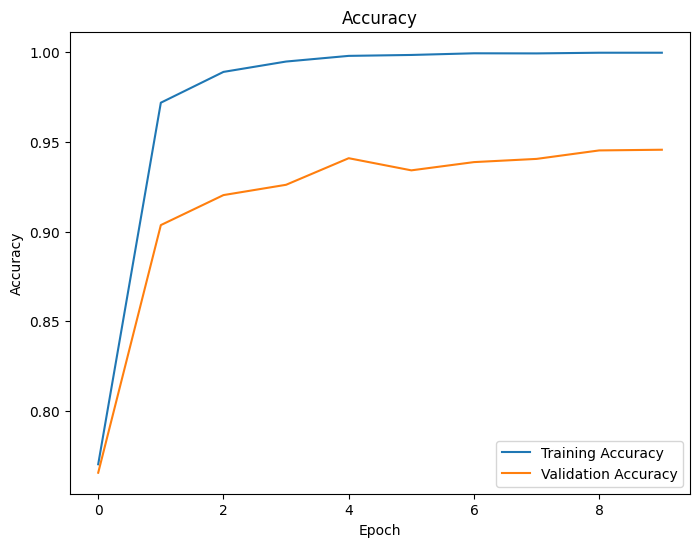

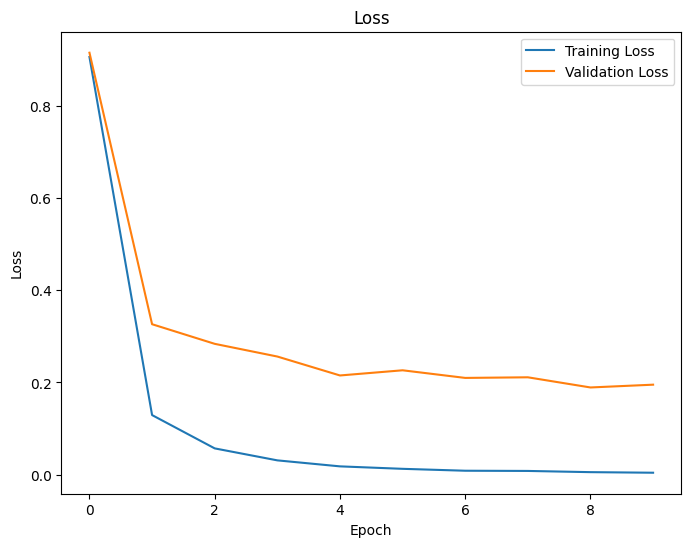

In [ ]:
# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save("CNN.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]


test_labels = test_df["ClassId"].values
imgs = test_df["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

2/2 [==============================] - 0s 139ms/step


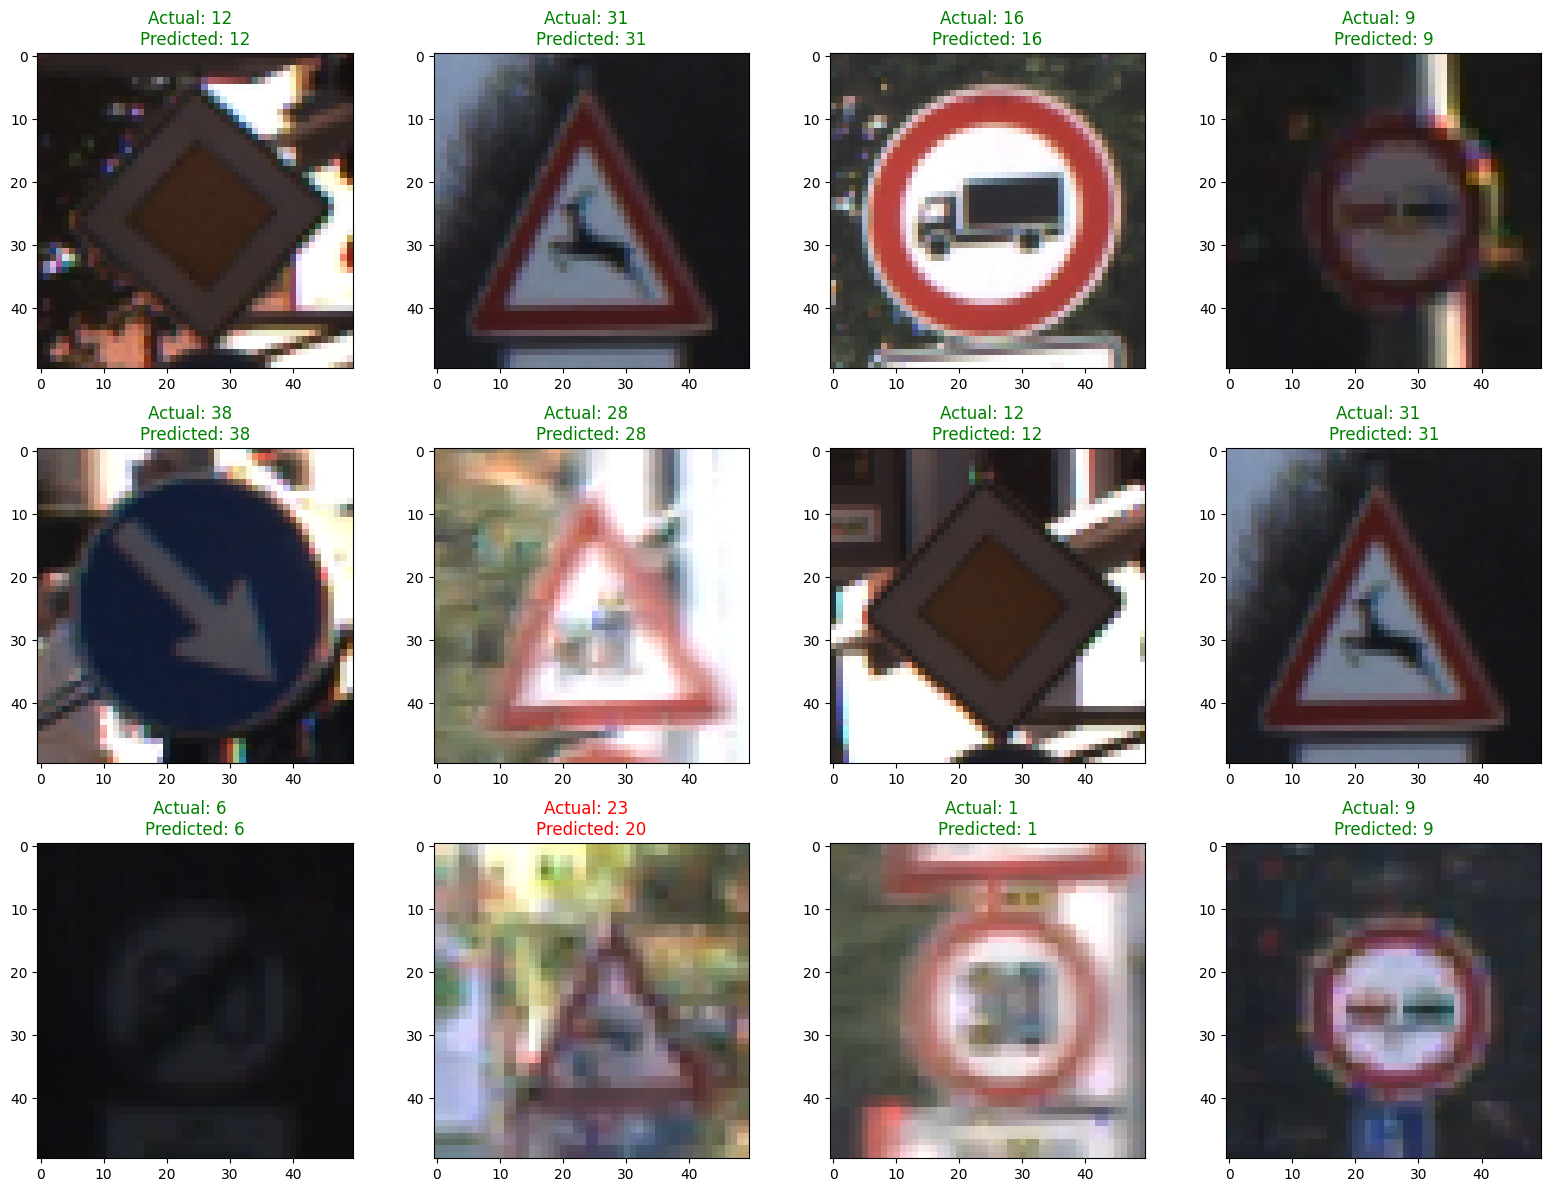

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))

for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()

In [ ]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

395/395 [==============================] - 50s 127ms/step
Test Data accuracy:  68.44813935075219


AttributeError: 'list' object has no attribute 'values'

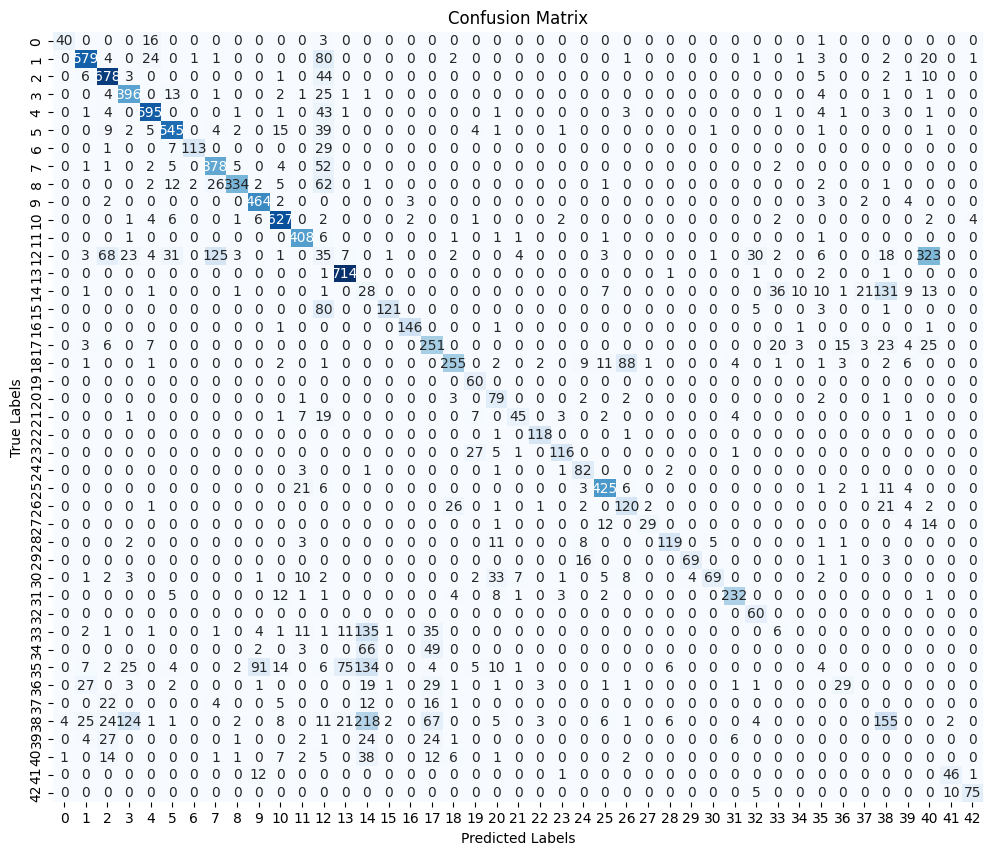

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(test_labels, pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(classes)), classes.values(), rotation=90)
plt.yticks(np.arange(len(classes)), classes.values())
plt.show()